#DATASCI W261: Machine Learning at Scale HW9
##Vineet Gangwar, James Route, Taylor Ma
####vineet.gangwar@gmail.com, james.route@gmail.com, taylorma@berkeley.edu
####W261-2: Machine Learning at Scale  
####Date: Nov 03, 2015

#HW9.0

**What is PageRank and what is it used for in the context of web search?**

PageRank is an algorithm used by Google Search to rank websites in search results. It is used as a way to measure the importance of a webpage, primarily based on the number of other pages that link to it, and those pages' PageRank score.

**What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady state distibuton?**

To leverage the machinery of Markov Chains to computer the steady steate distribution, the webgraph must be 'well-behaved', where 'well-behaved' is define as:

1. Irreducible: There is a path from every node to every other node. If we have a dangling node, we need to add a way for it to teleport to other nodes.
1. Aperiodic: The period, or greatest common divisor (GCD), of all cycle lengths is 1.

#Addendum questions from HW7.5.1: 

**Can we utilize combiners in the HW 7 to perform the shortest path implementation?**

Since the reducer in HW 7 performs an associative and commutative operation (pick the minimal distance and pick the non-null graph structure), we can reuse it with minimal modification as a combiner. The combiner can improve performance, if it receives enough records to aggregate that it offsets its cost for I/O processing. In HW9.3, we found that the combiner actually slowed down execution (each iteration took ~25 minutes instead of 20) so we didn't use it.

**Does order inversion help with the HW 7 shortest path implementation?**

Order inversion will help with HW7 when implementing the shortest path algorithm because it simplifies the logic in the combiner/reducer. There are two types of records that the reducer can  receive: one containing the graph structure, and one or more with distances and shortest paths. We can use order inversion to sort on distances (assuming we set the record with the graph structure to 0 distance), so that the first record is always the graph structure and the second is the record with the shortest path. Another advantage is that we can ignore any remaining records.

#HW9.1: MRJob implementation of basic PageRank
**Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7). Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network),  and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).**

We use two jobs to accomplish this task. The first job preprocess the input adjacency matrix so that nodes with empty adjacency lists are included. This step simplifies the PageRank implementation. The second job runs the PageRank algorithm and outputs the final result.

The code for preprocessing is shown below.

In [1]:
%load_ext autoreload

In [2]:
%%writefile preprocess.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
import ast
 
class Preprocess(MRJob):
    # use RawProtocol to get rid of quotes in the output
    OUTPUT_PROTOCOL = RawProtocol
    
    # for each line, mapper yields the node, its adjacency list, and any nodes it connects to
    def mapper(self, _, line):
        # parse input
        data = line.strip().split('\t')
        node = data[0]
        edges = ast.literal_eval(data[1])
        
        # yield the node and its structure
        yield node, edges
        
        # yield the connected nodes
        for k in edges.iterkeys():
            yield k, None
            
    # combiner aggregates entries per node, where possible
    def combiner(self, key, values):
        edges = {}
        
        for v in values:
            if v:
                edges = v
        
        yield key, edges
    
    # reducer aggregates all entries for each node
    def reducer(self, key, values):
        edges = {}
        
        # there will be at least one value for each node, some have empy adjacency lists
        # take the non-empty list, if it exists
        for v in values:
            if v:
                edges = v
        
        yield key, str(edges)
    
if __name__ == '__main__':
    Preprocess.run()

Overwriting preprocess.py


Now we run the preprocessing job on the data for HW9.1.

In [3]:
!chmod +x preprocess.py
!rm ./out/part*
!python ./preprocess.py PageRank-test_indexed.txt --output-dir=out --no-output --no-strict-protocols
!cat ./out/part*

using configs in /Users/tma/.mrjob.conf
creating tmp directory /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608
writing to /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608/step-0-mapper-sorted
> sort /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608/step-0-mapper_part-00000
writing to /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608/step-0-reducer_part-00000 -> out/part-00000
removing tmp directory /var/folders/vn/qnlf095n6rdd2t8z60ynmpr40000gn/T/preprocess.tma.20151101.204501.801608
1	{}
10	{u'5': 1}
11	{u'5': 1

Below is the PageRank algorithm for HW9.1. This algorithm handles PageRank score for dangling nodes with the following steps:
* the mapper yields each dangling node with a key of '\*' so it goes to the same reducer
* the reducer sums up the scores for all dangling nodes and writes the value to file
* the algorithm runs a second MRJob step that reads the score from file and broadcasts it to a second stage of reducers
* the reducers evenly distribute the score to all nodes and finish the calculation

We avoid using two different MRJob calls for each iteration, instead using one call with two steps. This approach should save time while scaling well since only a single value gets written by a single reducer at each iteration, no matter how large the graph is.

In [7]:
%%writefile pagerank9_1.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
import ast
import sys
 
class PageRank9_1(MRJob):
    # use RawProtocol to get rid of quotes in the output
    OUTPUT_PROTOCOL = RawProtocol
    # this is the alpha/teleport value for the PageRank formula
    #teleport = 0.15
    
    # this is a 2-step job. 
    # first step distributes pagerank score and calculates base pagerank per node
    # second step a reducer that handles teleportation and dangling pagerank score
    def steps(self):
        return [MRStep(mapper=self.mapper, combiner=self.combiner, reducer=self.reducer),
                MRStep(reducer_init=self.agg_init, reducer=self.aggregate)]

    # set command line option to get number of nodes in graph
    def configure_options(self):
        super(PageRank9_1, self).configure_options()
        self.add_passthrough_option(
            '--num-nodes',
            type=str,
            help='Number of nodes in graph.'
        )
        self.add_passthrough_option(
            '--alpha',
            type=str,
            help='Value for PageRank algorithm.'
        )
    
    # retrieve number of nodes from args
    def load_options(self, args):
        super(PageRank9_1, self).load_options(args)
        self.num = int(self.options.num_nodes)
        self.alpha = float(self.options.alpha)

    def mapper(self, _, line):
        # parse input and set up variables
        data = line.strip().split('\t')
        node = data[0]
        edges = ast.literal_eval(data[1])
        
        # the initial input has no pagerank, so check if there's a pagerank score or not
        if len(data) > 2:
            pr = float(data[2])
        
        # if no pagerank score, initialize to 1 divided by number of nodes
        else:
            pr = 1.0 / self.num
        
        # yield the node and its graph structure
        yield node, (edges, 0)
        
        # if the node's adjacency list is empty, send its pagerank score to a special reducer
        if len(edges) == 0:
            #sys.stderr.write('\nempty list')
            yield '*', (None, pr)
        
        # otherwise distribute pagerank to connected nodes
        else:
            for k in edges.iterkeys():
                yield k, (None, 1.0*pr/len(edges))
                
    # combiner aggregates records for each node
    def combiner(self, key, values):
        edges = {}
        pr = 0.0
        
        for v in values:
            if v[0]:
                edges = v[0]
            pr += v[1]
        
        yield key, (edges, pr)
            
    # reducer sums up pagerank scores for each node
    def reducer(self, key, values):
        edges = {}
        pr = 0.0
        
        # keep running total of pagerank, take the non-empty adjacency list if it exists
        for v in values:
            if v[0]:
                edges = v[0]
            pr += v[1]
        
        # if the key is '*', we're summing pagerank for dangling nodes. write the total to file
        if key == '*':
            #sys.stderr.write('\nwriting dangles')
            with open('/Users/tma/ucb/w261/hw9/dangle_pr.txt', 'w') as f:
                f.write(str(pr))
        
        # otherwise yield the total pagerank for the node
        else:
            yield key, (edges, pr)
    
    # init second reducer. read pagerank for dangling nodes and divide by total nodes in graph
    def agg_init(self):
        with open('/Users/tma/ucb/w261/hw9/dangle_pr.txt') as f:
            self.dangle = float(f.readline().strip()) / self.num
            
    # the second reducer completes the pagerank calculation and yields final results
    def aggregate(self, key, values):
        for v in values:
            edges, pr = v
            
        pr = self.alpha / self.num + (1 - self.alpha) * (self.dangle + pr)
            
        yield key, (str(edges)+'\t'+str(pr))
    
if __name__ == '__main__':
    PageRank9_1.run()

Overwriting pagerank9_1.py


We now run the PageRank algorithm on the preprocessed data set. This job terminates after a set number of iterations to mirror how HW9.3 is executed. The output closely matches what is given in the instructions.

In [8]:
%reload_ext autoreload
%autoreload 2
from pagerank9_1 import PageRank9_1

def hw_9_1(itr, alpha):
    
    for i in range(itr):
        if i == 0:
            fname = 'part-00000'
        else:
            fname = 'pagerank_out'+str(i)+'.txt'
        
        mr_job = PageRank9_1(args=[fname, '--num-node', '11', '--no-strict-protocols', '--alpha', str(alpha)])
        #print "iteration = "+str(i)
                           
        with open('pagerank_out'+str(i+1)+'.txt', 'w') as output:
        
            with mr_job.make_runner() as runner: 
                runner.run()
                for line in runner.stream_output():
                    output.write(line)
        
    # print results and clean up
    print "final output in ", 'pagerank_out'+str(i+1)+'.txt'
    !cat {'pagerank_out'+str(i+1)+'.txt'}
    !rm pagerank_out*
            
hw_9_1(50, 0.15)

final output in  pagerank_out50.txt
A	{}	0.0327814931594
B	{u'C': 1}	0.384369780953
C	{u'B': 1}	0.342941453369
D	{u'A': 1, u'B': 1}	0.0390870921
E	{u'B': 1, u'D': 1, u'F': 1}	0.0808856932346
F	{u'B': 1, u'E': 1}	0.0390870921
G	{u'B': 1, u'E': 1}	0.0161694790169
H	{u'B': 1, u'E': 1}	0.0161694790169
I	{u'B': 1, u'E': 1}	0.0161694790169
J	{u'E': 1}	0.0161694790169
K	{u'E': 1}	0.0161694790169


#HW9.2 Exploring PageRank teleportation and network plots
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 

Running hw9.1 code with different damping factors as below:

In directed graphs, arrows (actually just thicker stubs) are drawn at the head end

Using damping factor: 0.00
A	{}	1.84685596323e-11
B	{u'C': 1}	0.385321100873
C	{u'B': 1}	0.614678899021
D	{u'A': 1, u'B': 1}	2.01760579848e-11
E	{u'B': 1, u'D': 1, u'F': 1}	3.30860901713e-11
F	{u'B': 1, u'E': 1}	2.01760579848e-11
G	{u'B': 1, u'E': 1}	2.66428064874e-12
H	{u'B': 1, u'E': 1}	2.66428064874e-12
I	{u'B': 1, u'E': 1}	2.66428064874e-12
J	{u'E': 1}	2.66428064874e-12
K	{u'E': 1}	2.66428064874e-12


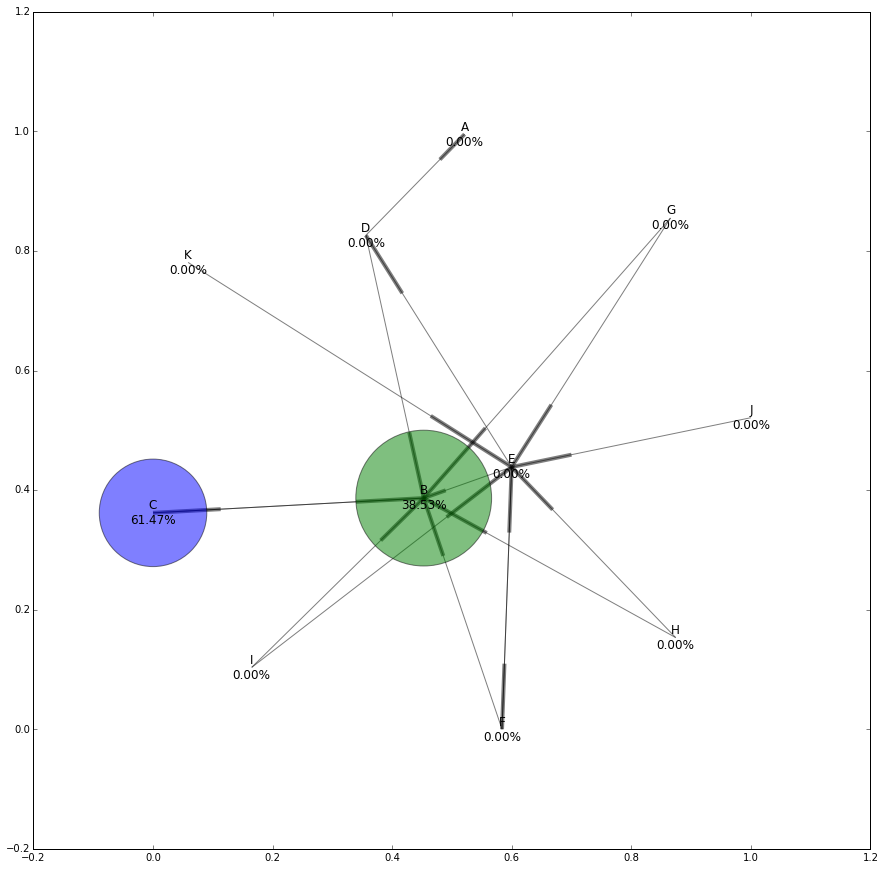

Using damping factor: 0.25
A	{}	0.0463014615642
B	{u'C': 1}	0.328716413627
C	{u'B': 1}	0.272421598198
D	{u'A': 1, u'B': 1}	0.0544460560079
E	{u'B': 1, u'D': 1, u'F': 1}	0.114247461787
F	{u'B': 1, u'E': 1}	0.0544460560079
G	{u'B': 1, u'E': 1}	0.0258841905612
H	{u'B': 1, u'E': 1}	0.0258841905612
I	{u'B': 1, u'E': 1}	0.0258841905612
J	{u'E': 1}	0.0258841905612
K	{u'E': 1}	0.0258841905612


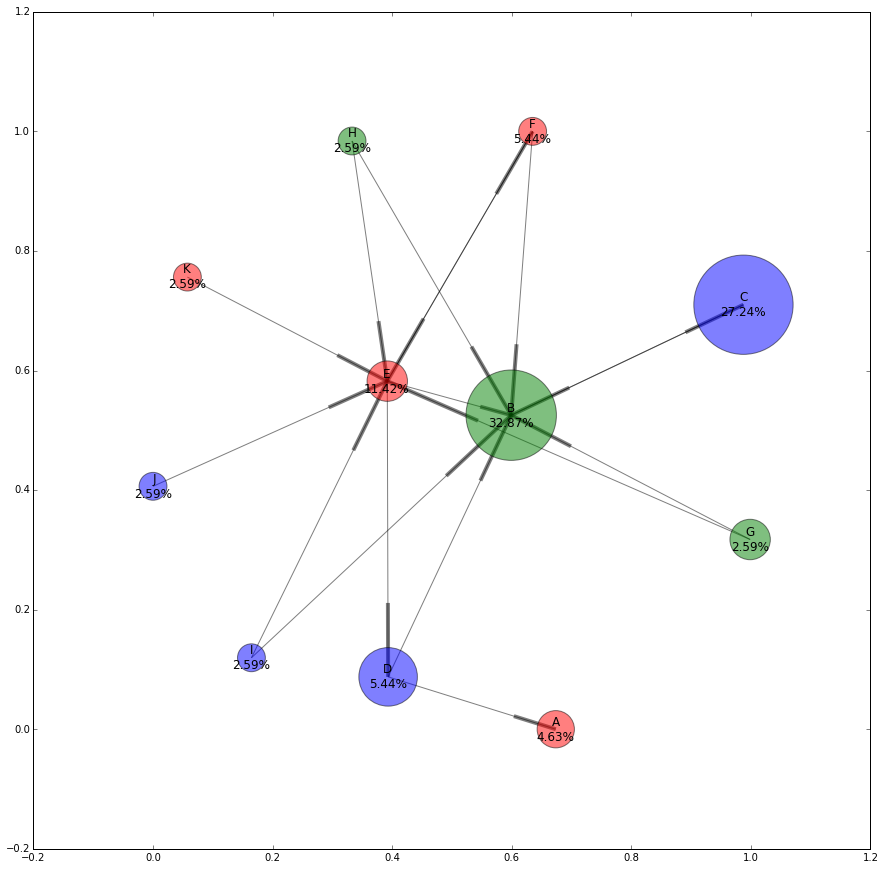

Using damping factor: 0.50
A	{}	0.0669478123353
B	{u'C': 1}	0.228430855737
C	{u'B': 1}	0.162713055702
D	{u'A': 1, u'B': 1}	0.0738007380074
E	{u'B': 1, u'D': 1, u'F': 1}	0.151818661044
F	{u'B': 1, u'E': 1}	0.0738007380074
G	{u'B': 1, u'E': 1}	0.0484976278334
H	{u'B': 1, u'E': 1}	0.0484976278334
I	{u'B': 1, u'E': 1}	0.0484976278334
J	{u'E': 1}	0.0484976278334
K	{u'E': 1}	0.0484976278334


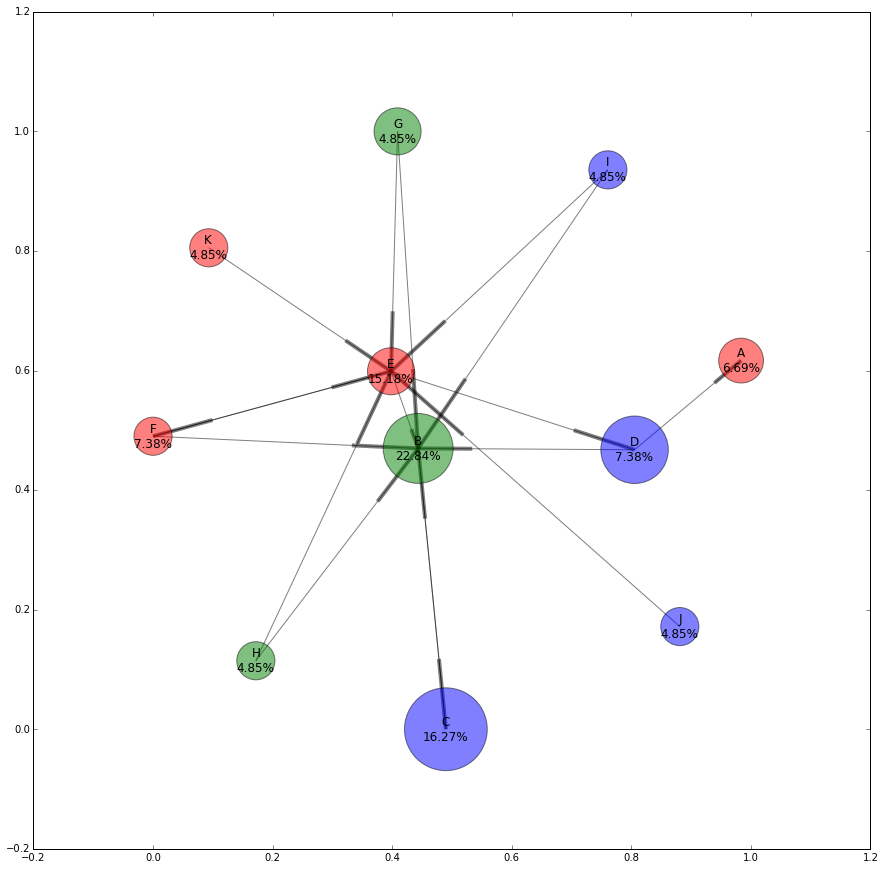

Using damping factor: 0.75
A	{}	0.080229666247
B	{u'C': 1}	0.155730909761
C	{u'B': 1}	0.108937947128
D	{u'A': 1, u'B': 1}	0.0817955724769
E	{u'B': 1, u'D': 1, u'F': 1}	0.141484233474
F	{u'B': 1, u'E': 1}	0.0817955724769
G	{u'B': 1, u'E': 1}	0.0700052196874
H	{u'B': 1, u'E': 1}	0.0700052196874
I	{u'B': 1, u'E': 1}	0.0700052196874
J	{u'E': 1}	0.0700052196874
K	{u'E': 1}	0.0700052196874


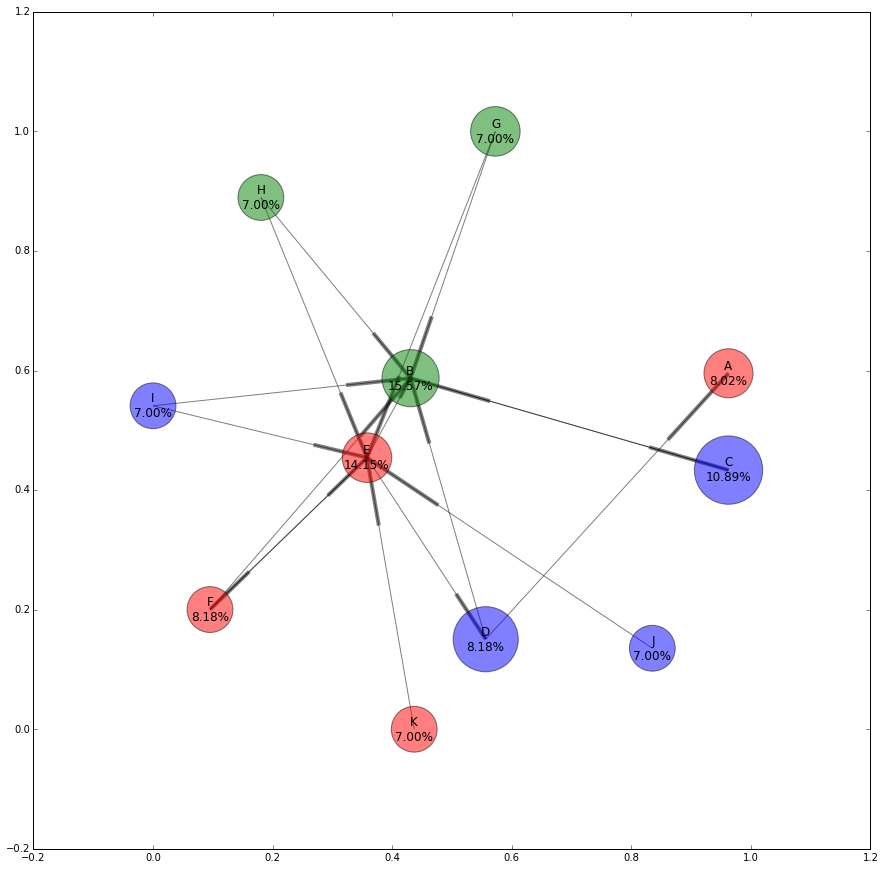

Using damping factor: 0.85
A	{}	0.0847833734744
B	{u'C': 1}	0.129766376668
C	{u'B': 1}	0.0978938206839
D	{u'A': 1, u'B': 1}	0.0847267905423
E	{u'B': 1, u'D': 1, u'F': 1}	0.125958527171
F	{u'B': 1, u'E': 1}	0.0847267905423
G	{u'B': 1, u'E': 1}	0.0784288641837
H	{u'B': 1, u'E': 1}	0.0784288641837
I	{u'B': 1, u'E': 1}	0.0784288641837
J	{u'E': 1}	0.0784288641837
K	{u'E': 1}	0.0784288641837


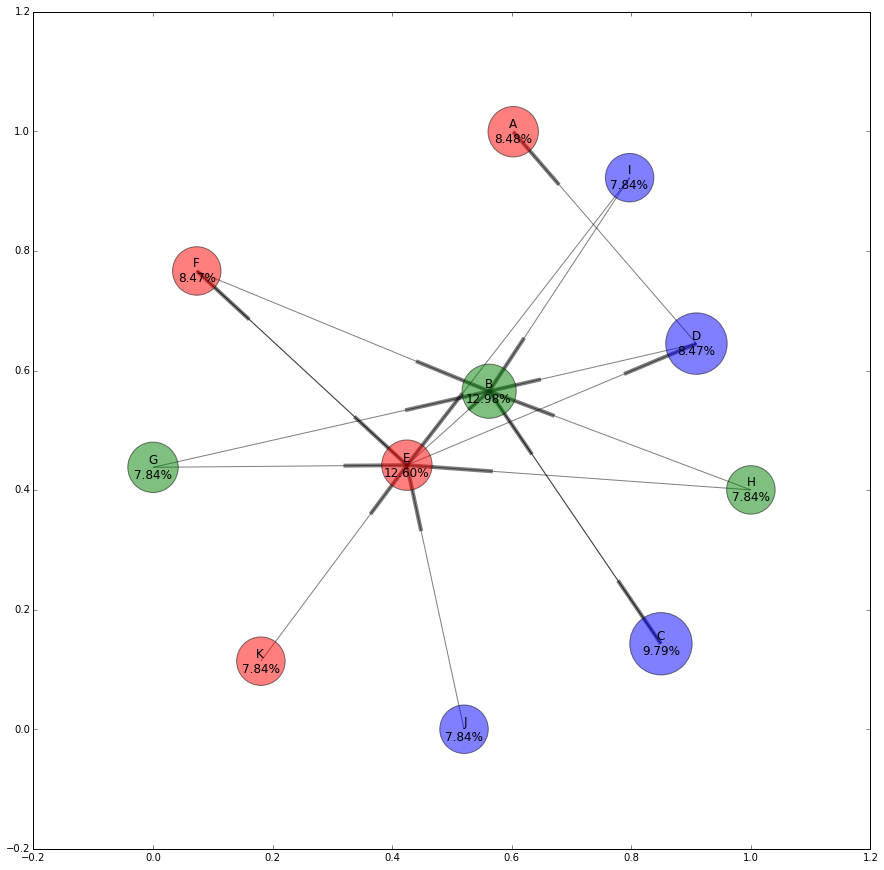

Using damping factor: 1.00
A	{}	0.0909090909091
B	{u'C': 1}	0.0909090909091
C	{u'B': 1}	0.0909090909091
D	{u'A': 1, u'B': 1}	0.0909090909091
E	{u'B': 1, u'D': 1, u'F': 1}	0.0909090909091
F	{u'B': 1, u'E': 1}	0.0909090909091
G	{u'B': 1, u'E': 1}	0.0909090909091
H	{u'B': 1, u'E': 1}	0.0909090909091
I	{u'B': 1, u'E': 1}	0.0909090909091
J	{u'E': 1}	0.0909090909091
K	{u'E': 1}	0.0909090909091


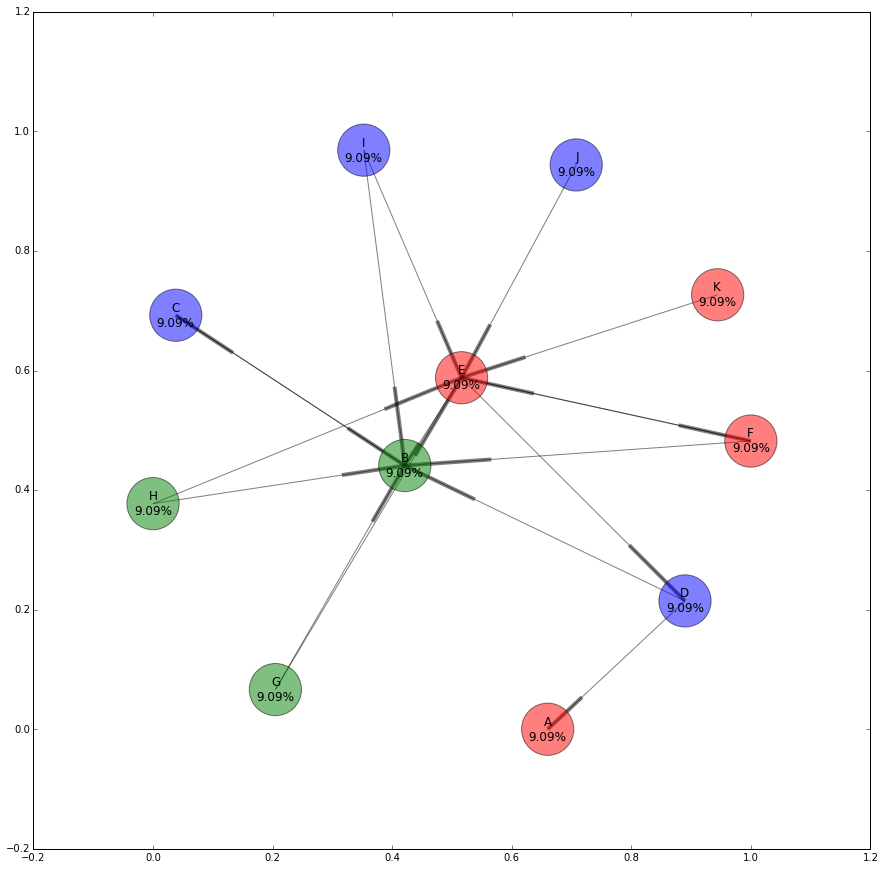

In [65]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pagerank9_1 import PageRank9_1
import ast
import sys
import networkx as nx
import matplotlib.pyplot as plt

def hw_9_2(itr, alpha):
    
    for i in range(itr):
        if i == 0:
            fname = 'part-00000'
        else:
            fname = 'pagerank_out'+str(i)+'.txt'
        
        mr_job = PageRank9_1(args=[fname, '--num-node', '11', '--no-strict-protocols', '--alpha', str(alpha)])
        #print "iteration = "+str(i)
                           
        with open('pagerank_out'+str(i+1)+'.txt', 'w') as output:
        
            with mr_job.make_runner() as runner: 
                runner.run()
                for line in runner.stream_output():
                    output.write(line)
        
    # print results and clean up
    !cat {'pagerank_out'+str(i+1)+'.txt'}

    final_fname = 'pagerank_out'+str(i+1)+'.txt'
    
    node_edges_dict = {}
    node_sizes_dict = {}
    with open(final_fname) as infile:
        for line in infile:
            data = line.strip().split('\t')
            node = data[0]
            edges = ast.literal_eval(data[1])
            size = data[2]

            node_edges_dict[node] = edges.keys()
            node_sizes_dict[node] = size

    def drawGraph(ne_dict, ns_dict):
        labels = {}
        node_sizes = []
        edges = []
        for k in sorted(ne_dict.keys()):
            labels[k] = k + "\n" + "%.2f" %round(float(ns_dict[k])*100,2)+"%"
            node_sizes.append(float(ns_dict[k])*30000)
            for end_node in ne_dict[k]:
                edges.append((k, str(end_node)))

        g = nx.DiGraph()
        g.add_nodes_from(labels.keys())
        g.add_edges_from(edges)
        
        fig, ax = plt.subplots(figsize=(15,15))

        nx.draw_networkx(g, 
                         node_size = node_sizes, 
                         labels = labels, 
                         with_labels = True,
                         arrows = True,
                         alpha = 0.5, ax = ax,
                         node_color=['r','b','g'])  
        plt.show()
        
    drawGraph(node_edges_dict, node_sizes_dict)   
    !rm pagerank_out*

print "In directed graphs, arrows (actually just thicker stubs) are drawn at the head end\n"
for alpha in [0,0.25,0.5,0.75, 0.85, 1]:
    print "Using damping factor: %.2f" %alpha
    hw_9_2(50, alpha)

#HW9.3: Applying PageRank to the Wikipedia hyperlinks network
**Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85). Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.**

For this problem, we interpreted *alpha* and *teleportation factor* as the same coefficient in the PageRank algorithm, based on equation 5.2 in the assigned reading.

As before, we preprocess the data and then run PageRank on it. For the preprocess and 10 interation job, I used 9 m1.large instances (pooling), which took around 3 hours to complete (approx. 20 minutes per iteration).

The output for all of the below commands is abridged to keep it from getting too long. We can provide the full output if needed.

In [11]:
# first, we preprocess the data
!./preprocess.py -r emr s3://261-ucb-wikipedia/all-pages-indexed-out.txt \
    --output-dir=s3://261-ucb-mids-jroute-output/wiki_data/ --no-output --no-strict-protocols \
    --pool-emr-job-flows

using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-6a2ee9ddf8558a4c
using s3://mrjob-6a2ee9ddf8558a4c/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/preprocess.jroute.20151101.012129.158763
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/preprocess.jroute.20151101.012129.158763/b.py
Copying non-input files into s3://mrjob-6a2ee9ddf8558a4c/tmp/preprocess.jroute.20151101.012129.158763/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
[OUTPUT REMOVED]
Job launched 1464.5s ago, status RUNNING: Running step (preprocess.jroute.20151101.012129.158763: Step 1 of 1)
Job completed.
Running time was 1080.0s (not counting time spent waiting for the EC2 instances)
ec2_key_pair_file not specified, going to S3
Fetching counters from S3...
Waiting 5.0s for S3 eventual consistency
Counters from step 1:
  File Input Format Counters :
    Bytes Read: 209

This is the PageRank algorithm from HW9.1. It's modified to run on EMR and it includes an additional command line option to configure the teleport/alpha value.

Note that we don't use the combiner implemented in HW9.1 because it actually slows execution. This is probably because the combiner doesn't see many records to aggregate and its additional I/O operations take time to execute.

In [2]:
%%writefile pagerank9_3.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
import ast
import sys
import boto
from boto.s3.key import Key

# write the total score for all dangling nodes to an S3 bucket for later retrieval
def write_dangling(p_rank):
    conn = boto.connect_s3("<The credentials are removed for submission>")
    bucket = conn.get_bucket('261-ucb-mids-jroute-output')
        
    k = Key(bucket)
    mykey = 'dangle'
    k.key = mykey
    k.set_contents_from_string(str(p_rank))
    conn.close()

# MRJob class for running PageRank in EMR
class PageRank9_3(MRJob):
    # user RawProtocol to get rid of quotes in the output
    OUTPUT_PROTOCOL = RawProtocol
    
    # this is a 2-step job. 
    # first step distributes pagerank score and calculates base pagerank per node
    # second step a reducer that handles teleportation and dangling pagerank score
    def steps(self):
        return [MRStep(mapper=self.mapper, reducer=self.reducer),
                MRStep(reducer_init=self.agg_init, reducer=self.aggregate)]
    
    # set command line options to get number of nodes in graph and teleport/alpha value
    def configure_options(self):
        super(PageRank9_3, self).configure_options()
        self.add_passthrough_option(
            '--num-nodes',
            type=str,
            help='Number of nodes in graph.'
        )
        self.add_passthrough_option(
            '--alpha',
            type=str,
            help='Value for PageRank algorithm.'
        )
    
    # retrieve values from args
    def load_options(self, args):
        super(PageRank9_3, self).load_options(args)
        self.num = int(self.options.num_nodes)
        self.alpha = float(self.options.alpha)
        
    
    def mapper(self, _, line):
        # parse input and set up variables
        data = line.strip().split('\t')
        node = data[0]
        edges = ast.literal_eval(data[1])
        
        # check to see if there's a pagerank score, otherwise initialize it
        if len(data) > 2:
            pr = float(data[2])
        
        else:
            pr = 1.0 / self.num
        
        # yield the node and its graph structure
        yield node, (edges, 0.0)
        
        # if adjacency list is empty, send to special reducer. otherwise distribute pagerank
        if len(edges) == 0:
            yield '*', (None, pr)
        else:
            for k in edges.iterkeys():
                yield k, (None, 1.0*pr/len(edges))
    
    # we don't use this because it slows execution. it is excluded from the steps() function
    def combiner(self, key, values):
        edges = {}
        pr = 0.0
        
        for v in values:
            if v[0]:
                edges = v[0]
            pr += v[1]
        
        yield key, (edges, pr)
            
    # add the pagerank from incoming links
    def reducer(self, key, values):
        edges = {}
        pr = 0.0
        
        # check for the adjacency list and keep running pagerank total
        for v in values:
            if v[0]:
                edges = v[0]
            pr += v[1]
        
        # check to see if we're working with dangling nodes. if so, write score to S3 bucket
        if key == '*':
            write_dangling(pr)
        
        # otherwise yield the node with new pagerank subtotal
        else:
            yield key, (edges, pr)
    
    # initalize second reducer stage by reading dangling node score from S3 and broadcasting it
    def agg_init(self):
        conn = boto.connect_s3("<The credentials are removed for submission>")
        bucket = conn.get_bucket('261-ucb-mids-jroute-output')
        k = Key(bucket)
        mykey = 'dangle'
        k.key = mykey
        self.dangle = float(k.get_contents_as_string()) / self.num
    
    # second reducer stage finishes the calculation
    def aggregate(self, key, values):
        for v in values:
            edges, pr = v
            
        pr = self.alpha / self.num + (1 - self.alpha) * (self.dangle + pr)
            
        yield key, (str(edges)+'\t'+str(pr))
    
if __name__ == '__main__':
    PageRank9_3.run()

Overwriting pagerank9_3.py


Run the code for 10 iterations on the data. The teleport/alpha value is set to 0.85. We set the number of nodes in the graph to 15192277. We calculated this value in the EDA exercise in HW7 and use the output here rather than re-running the code to save time. The same value can be found by counting the lines in the preprocessed input via MRJob.

In [1]:
# run 10 iterations of pagerank
def iterate10():

    for i in range(10):
        print 'iteration ', i+1

        # keep track of the input and output bucket locations
        if i == 0:
            fname = 's3://261-ucb-mids-jroute-output/wiki_data/'
        else:
            fname = 's3://261-ucb-mids-jroute-output/pagerank'+str(i)+'/'

        output = 's3://261-ucb-mids-jroute-output/pagerank'+str(i+1)+'/'

        # keep the results from the last two runs of pagerank only
        if i > 2:
            !aws s3 rm --recursive {'s3://261-ucb-mids-jroute-output/pagerank'+str(i-2)+'/'}

        !./pagerank9_3.py -r emr $fname --output-dir=$output --num-node 15192277 --alpha 0.85 \
        --no-strict-protocols --pool-emr-job-flows --max-hours-idle=1 --no-output

    # print results and clean up
    print 'final output in s3://261-ucb-mids-jroute-output/pagerank'+str(i+1)+'/'

iterate10()

iteration  1
using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-6a2ee9ddf8558a4c
using s3://mrjob-6a2ee9ddf8558a4c/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/pagerank9_3.jroute.20151101.033434.962043
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/pagerank9_3.jroute.20151101.033434.962043/b.py
Copying non-input files into s3://mrjob-6a2ee9ddf8558a4c/tmp/pagerank9_3.jroute.20151101.033434.962043/files/
Attempting to find an available job flow...
hash_object() is deprecated and will be removed in v0.5
Waiting 5.0s for S3 eventual consistency
[OUTPUT REMOVED]
Job launched 1298.5s ago, status RUNNING: Running step (pagerank9_3.jroute.20151101.070341.222272: Step 2 of 2)
Job completed.
Running time was 1259.0s (not counting time spent waiting for the EC2 instances)
ec2_key_pair_file not specified, going to S3
Fetching counters from S3...
Waiting 5.0s for S3 eventual con

This code reads the output of PageRank and takes the top 100 nodes, by PageRank score. The total number of nodes it outputs is dependent on the number of reducers. This code is mostly recycled from HW5.

In [2]:
%%writefile top100.py
#!/usr/bin/python

# sorting PageRank to pick top 100
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class Top100(MRJob):
    
    # read each line and output PageRank score as key. multiply the score by 100000000
    # because Hadoop sort doesn't handle scientific notation properly
    def mapper(self, _, line):
        data = line.strip().split('\t')
        node = data[0]
        edges = ast.literal_eval(data[1])
        pr = float(data[2]) * 100000000
        yield pr, node
        
    # configure the reducer to take only the top 100 PageRank scores it sees
    def reducer_init(self):
        self.threshold = 100  # Number of nodes to take
        self.counter = 0
        
    # output the top scores. PageRank gets converted back to its original value
    def reducer(self, pr, nodes):
        for node in nodes:
            if self.counter < self.threshold:
                pr /= 100000000
                yield pr, node
                self.counter += 1

    # configure a descending sort on the first column so the output is sorted accordingly
    def jobconf(self):
        orig_jobconf = super(Top100, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf
    
    def steps(self):
        return [
            MRStep(mapper         = self.mapper,
                   reducer_init   = self.reducer_init,
                   reducer        = self.reducer)
        ]

if __name__ == '__main__':
    Top100.run()

Overwriting top100.py


We use the above MRJob class to get the top PageRank scores from the output of the 10 iterations. This was done with 3 m1.medium instances.

In [10]:
!./top100.py -r emr s3://261-ucb-mids-jroute-output/pagerank10/ \
    --output-dir=s3://261-ucb-mids-jroute-output/iter10/ --no-strict-protocols --no-output

using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-6a2ee9ddf8558a4c
using s3://mrjob-6a2ee9ddf8558a4c/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top100.jroute.20151101.135546.044235
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top100.jroute.20151101.135546.044235/b.py
Copying non-input files into s3://mrjob-6a2ee9ddf8558a4c/tmp/top100.jroute.20151101.135546.044235/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-1TXUDK2J69H5L
Created new job flow j-1TXUDK2J69H5L
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.7s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.0s ago, status STARTING: Provisioning 

Now we run the PageRank job for 50 iterations. In order to complete 50 iterations in a more timely manner, I used 17 m2.xlarge instances. I did this on my personal Amazon account to avoid running up instance hours for everyone else. This job took 10 hours to complete (approx. 10 minutes per iteration).

In [15]:
# run 50 iterations of pagerank
def iterate50():
    for i in range(50):
        print 'iteration ', i+1

        # set the input and output S3 locations
        if i == 0:
            fname = 's3://261-ucb-mids-jroute-output/wiki_data/'
        else:
            fname = 's3://261-ucb-mids-jroute-output/pagerank50_'+str(i)+'/'

        output = 's3://261-ucb-mids-jroute-output/pagerank50_'+str(i+1)+'/'

        # keep the results from the last two iterations only
        if i > 2:
            !aws s3 rm --recursive {'s3://261-ucb-mids-jroute-output/pagerank50_'+str(i-2)+'/'} \
            --only-show-errors

        !./pagerank9_3.py -r emr $fname --output-dir=$output --num-node 15192277 --alpha 0.15 \
        --no-strict-protocols --pool-emr-job-flows --max-hours-idle=1 --no-output

    # print results and clean up
    print 'final output in s3://261-ucb-mids-jroute-output/pagerank50_'+str(i+1)+'/'
    
iterate50()

iteration  1
using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-6a2ee9ddf8558a4c
using s3://mrjob-6a2ee9ddf8558a4c/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/pagerank9_3.jroute.20151101.161523.593150
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/pagerank9_3.jroute.20151101.161523.593150/b.py
Copying non-input files into s3://mrjob-6a2ee9ddf8558a4c/tmp/pagerank9_3.jroute.20151101.161523.593150/files/
Attempting to find an available job flow...
hash_object() is deprecated and will be removed in v0.5
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
hash_object() is deprecated and will be removed in v0.5
Job flow created with ID: j-2AG1TNRPEV3AC
Created new job flow j-2AG1TNRPEV3AC
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched

And again, we process the output to take the top nodes. I used fewer instances this time but the job still took well under 60 minutes.

In [16]:
!./top100.py -r emr s3://261-ucb-mids-jroute-output/pagerank50_50/ \
    --output-dir=s3://261-ucb-mids-jroute-output/iter50/ --no-strict-protocols --no-output

using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-6a2ee9ddf8558a4c
using s3://mrjob-6a2ee9ddf8558a4c/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top100.jroute.20151102.030458.556560
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top100.jroute.20151102.030458.556560/b.py
Copying non-input files into s3://mrjob-6a2ee9ddf8558a4c/tmp/top100.jroute.20151102.030458.556560/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-1G3FG8OLILXLN
Created new job flow j-1G3FG8OLILXLN
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.4s ago, status STARTING: Provisioning 

For the final step, we retrieve the top-scoring nodes from each run of PageRank to compare the results and plot the scores.

Top 100 for a = 0.85, 10 iterations:	Top 100 nodes for a = 0.15, 50 iterations:
0.00021857674698300001	"13455888"	0.0014615599818999998	"13455888"
0.00015224418883499999	"1184351"	0.00066601779372100003	"1184351"
0.00011784673445800002	"1384888"	0.00063967737583099996	"4695850"
0.00011390425173200002	"6113490"	0.00057476719838999997	"5051368"
0.00010755262105600001	"4695850"	0.000450123222277	"1384888"
9.6115699082400011e-05	"5051368"	0.00044667005175999996	"2437837"
8.1316297223100006e-05	"7576704"	0.000444632244103	"6113490"
7.9897809735599994e-05	"6076759"	0.00044387869973500007	"7902219"
7.4303944696199994e-05	"9276255"	0.00043314218180900001	"13425865"
7.3307733203099995e-05	"7835160"	0.00042770776778100001	"6076759"
7.1945225687799995e-05	"4196067"	0.00042341679603700002	"4196067"
7.0121385504200002e-05	"2437837"	0.000397826042083	"6172466"
6.9529263522300001e-05	"15164193"	0.00038548623803	"14112583"
6.5398451118299996e-05	"14881689"	0.00036266653374299998	"10390714"
6.419996514

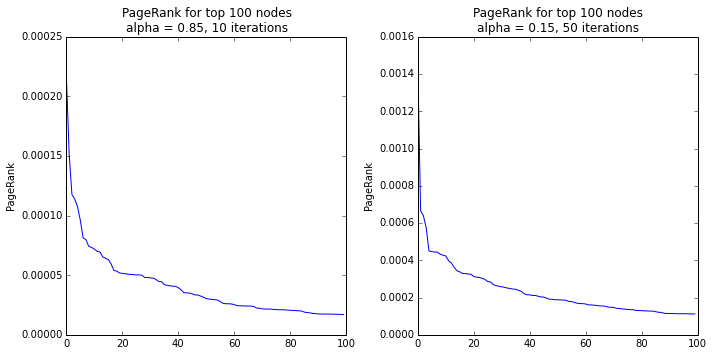

In [7]:
%matplotlib inline
from numpy import array, arange
import matplotlib.pyplot as plt

# display results from HW9.3
def display9_3():
    # pull the results of PageRank iterations from S3 and do final sort and merge
    !aws s3 sync s3://261-ucb-mids-jroute-output/iter10/ ./iter10 --only-show-errors
    !aws s3 sync s3://261-ucb-mids-jroute-output/iter50/ ./iter50 --only-show-errors
    !sort iter10/part* -k1gr | head -100 > iter10_sorted.txt
    !sort iter50/part* -k1gr | head -100 > iter50_sorted.txt

    # display side-by-side comparison of top 100 nodes from each run
    print "Top 100 for a = 0.85, 10 iterations:\tTop 100 nodes for a = 0.15, 50 iterations:"
    !paste -d'\t' iter10_sorted.txt iter50_sorted.txt

    # load the PageRank values from each run into a separate list
    data10 = list()
    data50 = list()

    with open('iter10_sorted.txt') as f:
        for line in f:
            data10.append(line.strip().split('\t')[0])

    with open('iter50_sorted.txt') as f:
        for line in f:
            data50.append(line.strip().split('\t')[0])

    data10 = array(data10)
    data50 = array(data50)

    # plot the PageRank values in each list as a line graph to show overall trend
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(data10)
    plt.title('PageRank for top 100 nodes\nalpha = 0.85, 10 iterations')
    plt.ylabel('PageRank')

    plt.subplot(1, 2, 2)
    plt.plot(data50)
    plt.title('PageRank for top 100 nodes\nalpha = 0.15, 50 iterations')
    plt.ylabel('PageRank')
    plt.tight_layout()
    plt.show()
    
display9_3()

The top 100 nodes from both runs of PageRank are fairly similar. The top 2 nodes in each list are the same, and many of the nodes that follow are the same, just ordered somewhat differently. On the whole, both algorithms are picking up the same nodes for the highest scores. The article titles for some of the top nodes are United States, Animal, France, Arthropod, Insect, and Germany, all of which we would expect to have many incoming links.

The graphs help to illustrate some of the differences. The nodes in the second PageRank run have much higher scores. In the first PageRank run, we set alpha to 0.85, so teleportation score, which is evenly split among nodes, is weighted heavily. In the second run alpha is only 0.15, so the PageRank scores are not distributed as evenly. Thus, the higher PageRank scores for the top nodes in run #2 come at the expense of the much lower-ranking nodes. Since the algorithm starts with uniform PageRank for all nodes, the higher number of iterations also provides more time to distribute scores in a less-uniform manner.

#HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

##Answer
The we have used several Map Reduce jobs to solve this problem. These jobs can be groups are data-preprocessing steps and the main Pagerank calculator job.  
**Pre-processing Steps**  
1. Count number of unique nodes in graph
 - Job name: **number_of_nodes_in_graph**  
 - Number of nodes: **100**  

The rest of the jobs are described below just above their respective codes

In [ ]:
%%writefile number_of_nodes_in_graph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

def get_neighbor_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    for node in neighbors.keys():
        yield node

class number_of_nodes_in_graph(MRJob):
    def mapper(self, _, line):
        node, neighbors = line.strip().split('\t')
        yield node, 1
        for neighbor in get_neighbor_nodes(neighbors):
            yield neighbor, 1
    
    def combiner(self, node, values):
        yield node, 1
    
    def reducer_init(self):
        self.c = 0
        
    def reducer(self, node, values):
        self.c += 1
        
    def reducer_final(self):
        yield "Number of Nodes", self.c
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       combiner      = self.combiner,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final)] 
    
if __name__ == '__main__':
    number_of_nodes_in_graph.run()

##Counting number of Nodes in graph

In [16]:
!python number_of_nodes_in_graph.py -r emr s3://ucb-mids-mls-networks/randNet.txt --emr-job-flow-id=j-1HH9ALUR6CK3S --jobconf mapreduce.job.reduces=1 

using configs in /home/vineetgangwar/.mrjob.conf
using existing temp bucket mrjob-ac09d775ff5e08f8
using s3://mrjob-ac09d775ff5e08f8/tmp/ as our temp dir on S3
creating tmp directory /tmp/number_of_nodes_in_graph.vineetgangwar.20151102.062147.534897
Copying non-input files into s3://mrjob-ac09d775ff5e08f8/tmp/number_of_nodes_in_graph.vineetgangwar.20151102.062147.534897/files/
Adding our job to existing job flow j-1HH9ALUR6CK3S
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as follows
 mapred.reduce.tasks: mapreduce.job.reduces
Job launched 32.2s ago, status RUNNING: Running step (number_of_nodes_in_graph.vineetgangwar.20151102.062147.534897: Step 1 of 1)
Job launched 63.2s ago, status RUNNING: Running step (number_of_nodes_in_graph.vineetgangwar.20151102.062147.534897: Step 1 of 1)
Job launched 94.4s ago, status RUNNING: Running step (number_of_nodes_in_graph.vineetgangwar.20151102.062147.534897: Step 1 of 1)
Job launched 

##Pre-processing step #2 - Counting number of pages per topic 
This job counts the number of pages per topic and stored them in S3 at **s3://ucb-mids-mls-vineetgangwar/HW9/4/pages_per_topic**

In [4]:
%%writefile number_of_pages_per_topic.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class number_of_pages_per_topic(MRJob):
    def mapper(self, _, line):
        node, topic = line.strip().replace('"', '').split('\t')
        yield topic, 1
        
    def reducer(self, topic, counts):
        yield topic, sum(counts)

    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer       = self.reducer)] 
    
if __name__ == '__main__':
    number_of_pages_per_topic.run()

Overwriting number_of_pages_per_topic.py


In [6]:
!python number_of_pages_per_topic.py -r emr s3://ucb-mids-mls-networks/randNet_topics.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/4/pages_per_topic --emr-job-flow-id=j-1HH9ALUR6CK3S --jobconf mapreduce.job.reduces=1        

using configs in /home/vineetgangwar/.mrjob.conf
using existing temp bucket mrjob-ac09d775ff5e08f8
using s3://mrjob-ac09d775ff5e08f8/tmp/ as our temp dir on S3
creating tmp directory /tmp/number_of_pages_per_topic.vineetgangwar.20151102.035306.038110
Copying non-input files into s3://mrjob-ac09d775ff5e08f8/tmp/number_of_pages_per_topic.vineetgangwar.20151102.035306.038110/files/
Adding our job to existing job flow j-1HH9ALUR6CK3S
Detected hadoop configuration property names that do not match hadoop version 2.4.0:
The have been translated as follows
 mapred.reduce.tasks: mapreduce.job.reduces
Job launched 31.1s ago, status WAITING: Waiting after step completed (number_of_pages_per_topic.vineetgangwar.20151102.035306.038110: Step 1 of 1)
Job launched 62.3s ago, status RUNNING: Running step (number_of_pages_per_topic.vineetgangwar.20151102.035306.038110: Step 1 of 1)
Job launched 93.3s ago, status RUNNING: Running step (number_of_pages_per_topic.vineetgangwar.20151102.035306.038110: Step 

##Pre-processing step #3 - Adding initial PageRank vector as payload to the adjacency list
This job reads the entire graph line by line and appends the initial pagerank vector to the adjacency list  
The initial pagerank vector is a list of probabilities separated by a ~ character   
Initial probabilities for each vector component is set to 1/nodes_in_graph  
The reducer also adds a blank adjacency list for dangling nodes and appends the pagerank vector to it  
The output is stored at **s3://ucb-mids-mls-vineetgangwar/HW9/4/topic_to_adjacency**  
e.g. "1"	"{'11': 1, '27': 1, '46': 1, '47': 1, '35': 1, '89': 1, '63': 1, '5': 1};0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01"

In [19]:
%%writefile add_pagerank_to_payload.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import os

def get_topic_pagerank_vector():
    num_of_topics = int(os.environ['numTopics'])
    num_nodes_in_graph = int(os.environ['numNodes'])
    total_pagerank_vector = num_of_topics + 1
    return '~'.join([str(1/float(num_nodes_in_graph)) for i in xrange(total_pagerank_vector)])

class add_pagerank_to_payload(MRJob):
    def mapper(self, _, line):        
        node, neighbors = line.strip().replace('"', '').split('\t')
        payload = ';'.join((neighbors, get_topic_pagerank_vector()))
        yield node, payload
    
    def reducer_init(self):
        num_nodes_in_graph = int(os.environ['numNodes'])
        self.set_of_all_nodes = set(range(1, num_nodes_in_graph+1))
        self.nodes_in_adjacency_list = set()
    
    def reducer(self, node, payloads):
        for payload in payloads:
            yield node, payload
            node = int(node)
            self.nodes_in_adjacency_list.add(node)
    
    def reducer_final(self):
        diff_nodes = self.set_of_all_nodes - self.nodes_in_adjacency_list
        for node in diff_nodes:
            yield str(node), ';'.join(('{}', get_topic_pagerank_vector()))
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final)] 
    
if __name__ == '__main__':
    add_pagerank_to_payload.run()

Overwriting add_pagerank_to_payload.py


In [32]:
!python add_pagerank_to_payload.py -r emr s3://ucb-mids-mls-networks/randNet.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/4/topic_to_adjacency --emr-job-flow-id=j-1HH9ALUR6CK3S --cmdenv=numNodes=100 --cmdenv=numTopics=10 --no-output --jobconf mapreduce.job.reduces=1   

using configs in /home/vineetgangwar/.mrjob.conf
using existing temp bucket mrjob-ac09d775ff5e08f8
using s3://mrjob-ac09d775ff5e08f8/tmp/ as our temp dir on S3
creating tmp directory /tmp/add_pagerank_to_payload.vineetgangwar.20151102.071144.892456
Copying non-input files into s3://mrjob-ac09d775ff5e08f8/tmp/add_pagerank_to_payload.vineetgangwar.20151102.071144.892456/files/
Adding our job to existing job flow j-1HH9ALUR6CK3S
Job launched 31.1s ago, status RUNNING: Running step (add_pagerank_to_payload.vineetgangwar.20151102.071144.892456: Step 1 of 1)
Job launched 63.3s ago, status RUNNING: Running step (add_pagerank_to_payload.vineetgangwar.20151102.071144.892456: Step 1 of 1)
Job launched 94.6s ago, status RUNNING: Running step (add_pagerank_to_payload.vineetgangwar.20151102.071144.892456: Step 1 of 1)
Job completed.
Running time was 82.0s (not counting time spent waiting for the EC2 instances)
Waiting 5.0s for S3 eventual consistency
looking for job logs in s3://mrjob-ac09d775ff5e0

##Pre-procesding step #4 - Adding topic to payload
This job performs a reduce-side join. It takes two sources as inputs:  
- The output of the previous job  
- Index to topic mapping  
The topic is added to the adjacency list. The adjacency list now is the in the following format:  
< Adjacency list >;< topic >;< PageRank vector separated by ~ >  
e.g.  
"11"	"{'39': 1, '12': 1, '21': 1, '55': 1, '43': 1, '46': 1, '89': 1, '7': 1, '84': 1};6;0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01~0.01"  
The output gets stored at **s3://ucb-mids-mls-vineetgangwar/HW9/4/1**  

In [12]:
%%writefile add_topic_to_payload.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import os

class add_topic_to_payload(MRJob):
    def mapper(self, _, line):
        node, payload = line.strip().replace('"', '').split('\t')
        yield node, payload
    
    def reducer(self, node, payloads):
        p1, p2 = payloads
        p1 = p1.split(';')
        p2 = p2.split(';')

        if len(p1) == 2:
            payload = ';'.join((p1[0], p2[0], p1[1]))
        else:
            payload = ';'.join((p2[0], p1[0], p2[1]))
        yield node, payload
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer       = self.reducer)] 
    
if __name__ == '__main__':
    add_topic_to_payload.run()

Overwriting add_topic_to_payload.py


In [13]:
!python add_topic_to_payload.py -r emr s3://ucb-mids-mls-vineetgangwar/HW9/4/topic_to_adjacency/ s3://ucb-mids-mls-networks/randNet_topics.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/4/1 --emr-job-flow-id=j-20GG1PMJDZSGK --no-output      

using configs in /home/vineetgangwar/.mrjob.conf
using existing temp bucket mrjob-ac09d775ff5e08f8
using s3://mrjob-ac09d775ff5e08f8/tmp/ as our temp dir on S3
creating tmp directory /tmp/add_topic_to_payload.vineetgangwar.20151102.172648.062523
Copying non-input files into s3://mrjob-ac09d775ff5e08f8/tmp/add_topic_to_payload.vineetgangwar.20151102.172648.062523/files/
Adding our job to existing job flow j-20GG1PMJDZSGK
Job launched 31.1s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151102.172648.062523: Step 1 of 1)
Job launched 63.4s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151102.172648.062523: Step 1 of 1)
Job launched 94.6s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151102.172648.062523: Step 1 of 1)
Job launched 126.8s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151102.172648.062523: Step 1 of 1)
Job completed.
Running time was 112.0s (not counting time spent waiting

##Job to calculate PageRank vector in 50 iterations
This job consists of 2 steps:  
###Step 1:  
- Mapper
 - Reads each line generated in the previous job line by line  
 - It removes PageRank vector from the payload  
 - Appends the string 'adjacency list' to the payload 
 - Emits Node and the new payload
 - It then calculates new partial probabilities vector by dividing the original PageRank vector by the number of neighbors
 - It then computes a new payload made consisting of - The string 'partial_prob' and the new pagerank vector separated by a semi-colon
 - It emits each neighbor along with the new payload
- Reducer
 - For all the dangling nodes the reducer adds up all the probabilities and writes it to S3 in the location **s3://ucb-mids-mls-vineetgangwar/HW9/4/dangling**  
 - For rest of the keys, the reducer adds up the probability vector
 - The reducer the computes a new payload for each node that consists of - < Adjacency list >; < Topic >; < New PageRank vector computed just above >  
 - It then emits the node and the new PageRank vector
 
###Step 2:
This step takes care of Dangling node mass and teleportation
- Mapper
 - The mapper reads the dangling mass from S3 that was computed in the previous step  
 - It also reads the number of nodes per topic from S3 (This was computed in the pre-processing stage)  
 - For each node, the new global page rank vector is calculated as per the formula:
 $(alpha/nodesInGraph) + (1-alpha)*(globalDangling/nodesInGraph + globalPagerank)$
 - For each node, if the node belongs to the topic in question then the new topic specific pagerank is calculated as per the formula:
 $beta*(alpha/numberOfNodesInTopic) + (1-alpha)*(danglingSumForTopic/nodesInGraph + pagerankOfTopic)$
 - If node does not belong to the topic in question:  
 $(1-beta)*(alpha/numberOfNodesInTopic) + (1-alpha)*(danglingSumForTopic/nodesInGraph + pagerankOfTopic)$
 - The mapper then replaces the pagerank vector in the payload with the newly computed pagerank vector (that handles danlging + teleportation)
 - It emits node along with the new payload
 
###Driver
The driver executes 50 iterations. At the end of each iterations it deletes the data generated in the previous step  
The final output is stored at **s3://ucb-mids-mls-vineetgangwar/HW9/4/51**  

###Cluster Size
<img src="https://s3-us-west-2.amazonaws.com/group-x-hw9-screenshot/cluster94.png">

In [14]:
%%writefile hw94.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
import ast
import os
import boto
from boto.s3.key import Key
import urllib2
import numpy as np

'''
Input to reducer
"1"	    ["partial_prob",0.0454545455]
"10"	["adjacency_list","{'5': 1}"]
"11"	["adjacency_list","{'5': 1}"]
"2"	    ["adjacency_list","{'3': 1}"]
"2"	    ["partial_prob",0.0303030303]
'''

def get_neighbor_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    for node in neighbors.keys():
        yield node
        
def get_num_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    return len(neighbors)

def get_prob_mass_vector(prob_mass, num_of_neighbors):
    prob_mass_list = prob_mass.split('~')
    return '~'.join([str(float(p)/num_of_neighbors) for p in prob_mass_list])

def add_prob_vector(current, new):
    current_np = np.array(current.split('~')).astype(float)
    new_np = np.array(new.split('~')).astype(float)
    return '~'.join((current_np + new_np).astype(str))

class hw94(MRJob):
    def mapper(self, _, line):
        node, payload = line.strip().replace('"', '').split('\t')
        neighbors, topic, pagerank = payload.split(';')
        yield node, ('adjacency_list', neighbors, topic)
        
        num_of_neighbors = get_num_nodes(neighbors)
        for neighbor in get_neighbor_nodes(neighbors):
            yield neighbor, ('partial_prob', get_prob_mass_vector(pagerank, num_of_neighbors))
        
        if num_of_neighbors == 0:
            yield "dangling", pagerank
    
    def reducer_init(self):
        num_of_topics = int(os.environ['numTopics'])
        self.total_pagerank_vector = num_of_topics + 1
        self.dangling_sum = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        self.dangling_null = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        
    def reducer(self, node, payloads):
        num_of_topics = int(os.environ['numTopics'])
        total_pagerank_vector = num_of_topics + 1
    
        prob_sum = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        
        neighbors = str()
        topic = str()
        num_of_partial_probs = 0
        
        for payload in payloads:
            if payload[0] == 'adjacency_list':
                neighbors = payload[1]
                topic = payload[2]
            elif payload[0] == 'partial_prob':
                prob_sum = add_prob_vector(prob_sum, payload[1])
                num_of_partial_probs += 1
            elif node == 'dangling':
                self.dangling_sum = add_prob_vector(self.dangling_sum, payload)
        if node != 'dangling':
            yield node, ';'.join((neighbors, topic, str(prob_sum)))
    
    def reducer_final(self):
        #Write dangling sum out
        if self.dangling_sum != self.dangling_null:
            conn = boto.connect_s3('<Credentials Here')
            bucket = conn.get_bucket('ucb-mids-mls-vineetgangwar')

            k = Key(bucket)
            mykey = 'HW9/4/dangling'
            k.key = mykey
            k.set_contents_from_string(str(self.dangling_sum))
    
    def dangling_teleportation_init(self):
        # Reading dangling from S3
        self.dangling_sum = str()
        s3_path = 'https://s3.amazonaws.com/ucb-mids-mls-vineetgangwar/HW9/4/dangling'
        filehndl = urllib2.urlopen(s3_path)
        self.dangling_sum = filehndl.read()
        filehndl.close()
        
        # Reading topic and counts from S3 and storing as a list of tuples
        self.topic_count = list()
        s3_path = 'https://s3.amazonaws.com/ucb-mids-mls-vineetgangwar/HW9/4/pages_per_topic/part-00000'
        filehndl = urllib2.urlopen(s3_path)
        for line in filehndl:
            topic, count = line.strip().replace('"', '').split('\t')
            self.topic_count.append((topic, count))
        filehndl.close()
        self.topic_count = sorted(self.topic_count, key=lambda item: int(item[0]))

    def handling_dangling_and_teleportation(self, node, payload):
        nodes_in_graph = float(os.environ['numNodes'])
        alpha = float(os.environ['alpha'])
        dangling_sum = self.dangling_sum
        topic_count = self.topic_count
        beta = float(os.environ['beta'])
        new_page_rank_vector = list()
        
        neighbors, topic, pagerank = payload.split(';')
        
        # Converting pagerank into list
        pagerank_list = [float(p) for p in pagerank.split('~')]
        # Converting dangling into list
        dangling_sum_list = [float(d) for d in dangling_sum.split('~')]
        # Getting global pagerank and global dangling
        global_pagerank = float(pagerank_list.pop())
        global_dangling = dangling_sum_list.pop()
        
        new_global_pagerank = (alpha/nodes_in_graph) + (1-alpha)*(global_dangling/nodes_in_graph + global_pagerank)

        for x in xrange(len(pagerank_list)):
            tuple_topic, tuple_count = topic_count[x]
            tuple_count = float(tuple_count)
            if tuple_topic == topic:
                topic_pagerank = beta*(alpha/tuple_count) + (1-alpha)*(dangling_sum_list[x]/nodes_in_graph + pagerank_list[x])
            else:
                topic_pagerank = (1-beta)*(alpha/(nodes_in_graph-tuple_count)) + (1-alpha)*(dangling_sum_list[x]/nodes_in_graph + pagerank_list[x])
            new_page_rank_vector.append(str(topic_pagerank))
        new_page_rank_vector.append(str(new_global_pagerank))
        new_page_rank_vector = '~'.join(new_page_rank_vector)
        yield node, ';'.join((neighbors, topic, new_page_rank_vector))
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final),
                MRStep(mapper_init   = self.dangling_teleportation_init,
                       mapper        = self.handling_dangling_and_teleportation)] 
    
if __name__ == '__main__':
    hw94.run()

Overwriting hw94.py


In [15]:
import boto
from boto.s3.key import Key

for i in xrange(50):
    #Initializing Dangling probability mass vector in S3 to 0.0~0.0~0.0 ...
    conn = boto.connect_s3('Credentials Here')
    bucket = conn.get_bucket('ucb-mids-mls-vineetgangwar')
    numTopics = 10
    total_pagerank_vector = numTopics + 1
    k = Key(bucket)
    mykey = 'HW9/4/dangling'
    k.key = mykey
    dangling_str = '~'.join([str(0.0) for y in xrange(total_pagerank_vector)])
    k.set_contents_from_string(dangling_str)

    print '>>Iteration:', i
    input_path = 's3://ucb-mids-mls-vineetgangwar/HW9/4/' + str(i+1) + '/'
    output_path = '--output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/4/' + str(i+2)
    print input_path, output_path
    !python hw94.py -r emr $input_path $output_path --cmdenv=alpha=0.15 --cmdenv=numNodes=100 --cmdenv=numTopics=10 --cmdenv=beta=0.99 --emr-job-flow-id=j-20GG1PMJDZSGK --no-output   
    !aws s3 rm $input_path --recursive --only-show-errors

>>Iteration: 0
s3://ucb-mids-mls-vineetgangwar/HW9/4/1/ --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/4/2
using configs in /home/vineetgangwar/.mrjob.conf
using existing temp bucket mrjob-ac09d775ff5e08f8
using s3://mrjob-ac09d775ff5e08f8/tmp/ as our temp dir on S3
creating tmp directory /tmp/hw94.vineetgangwar.20151102.173006.064972
Copying non-input files into s3://mrjob-ac09d775ff5e08f8/tmp/hw94.vineetgangwar.20151102.173006.064972/files/
Adding our job to existing job flow j-20GG1PMJDZSGK
Job launched 31.2s ago, status RUNNING: Running step (hw94.vineetgangwar.20151102.173006.064972: Step 1 of 2)
Job launched 63.5s ago, status RUNNING: Running step (hw94.vineetgangwar.20151102.173006.064972: Step 1 of 2)
Job launched 94.6s ago, status RUNNING: Running step (hw94.vineetgangwar.20151102.173006.064972: Step 1 of 2)
Job launched 126.0s ago, status RUNNING: Running step (hw94.vineetgangwar.20151102.173006.064972: Step 2 of 2)
Job launched 157.2s ago, status RUNNING: Running step (hw9

The code below is a short MRJob that takes the top 10 nodes for each of the topics (10 plus 1 generic) used in HW9.4. It splits each line from the output of the topical PageRank algorithm into 11 parts (one for each topic) and emits each part. The reducers each look at nodes for a specific topic and output the top 10 based on PageRank score.

In [22]:
%%writefile top10.py
#!/usr/bin/python

# sorting PageRank to pick top 10 nodes for each topic
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
import ast

class Top10(MRJob):
    # use RawProtocol to get rid of quotes in the output
    OUTPUT_PROTOCOL = RawProtocol
    
    # parse each line and output 11 items, one for each topic
    def mapper(self, _, line):
        # first split gets us the node and the payload
        data = line.strip().split('\t')
        node = data[0].strip('"')
        
        # second split divides payload into topic, adjacency list, and topic scores
        payload = data[1].strip('"').split(';')
        topic = payload[1]
        
        # third split gives us the array of topic scores
        scores = payload[2].split('~')
        
        # for each topic number, emit the node, its topic, and its pagerank score
        for i in range(11):
            pr = float(scores[i])
            yield i, (node, topic, pr)
        
    # each reducer handles all scores for a specific topic and outputs the top 10
    def reducer(self, topic_ind, values):
        # holds top 10 nodes for the topic
        scores = list()
        
        # examine scores for a given topic
        # list is kept sorted at all times. since it is only length 10, this is inexpensive
        for v in values:
            node, topic, pr = v
            # if fewer than 10 items in list, append node
            if len(scores) < 10:
                scores.append((node, topic, pr))
                scores.sort(key=lambda i: i[2], reverse=True)
            
            # otherwise check if pagerank is greater than min in list and replace if needed
            elif pr > scores[-1][2]:
                scores.pop()
                scores.append((node, topic, pr))
                scores.sort(key=lambda i: i[2], reverse=True)
        
        # output the top 10 nodes for the topic
        for item in scores:
            yield 'topic  '+str(topic_ind+1), item[0]+'\t'+item[1]+'\t'+str(item[2])

if __name__ == '__main__':
    Top10.run()

Overwriting top10.py


Now we run the code on the output from 50 iterations of PageRank (using 1 m1.small). The output shows the top nodes for each topic number (topic 11 is the generic topic). Each row lists the topic number, the node, the node's assigned topic, and the PageRank score. For each topic, all (or nearly all) of the top nodes are assigned to the topic, and any exceptions tend to be near the bottom of the list. This is expected, since nodes in the topic receive nearly all of the score from teleporting. In contrast, the generic topic has nodes from many different topics. This is also expected, since the score from teleporting is divided across all nodes.

In [19]:
!./top10.py -r emr s3://ucb-mids-mls-vineetgangwar/HW9/4/51/ --no-strict-protocols

using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-0ce045e5d862c5e4
using s3://mrjob-0ce045e5d862c5e4/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top10.jroute.20151103.040334.829449
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top10.jroute.20151103.040334.829449/b.py
Copying non-input files into s3://mrjob-0ce045e5d862c5e4/tmp/top10.jroute.20151103.040334.829449/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-JERM2ZG2WZBB
Created new job flow j-JERM2ZG2WZBB
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 122.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 152.4s ago, status STARTING: Provisioni

#HW 9.5: Applying topic-specific PageRank to Wikipedia

Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.

##Answer
The we have used several Map Reduce jobs to solve this problem. These jobs can be groups are data-preprocessing steps and the main Pagerank calculator job.  
**Pre-processing Steps**  
1. Count number of unique nodes in graph
 - Job name: **number_of_nodes_in_graph**  
 - Number of nodes: **15192277**  

The rest of the jobs are described below just above their respective codes

In [7]:
%%writefile number_of_nodes_in_graph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

def get_neighbor_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    for node in neighbors.keys():
        yield node

class number_of_nodes_in_graph(MRJob):
    def mapper(self, _, line):
        node, neighbors = line.strip().split('\t')
        yield node, 1
        for neighbor in get_neighbor_nodes(neighbors):
            yield neighbor, 1
    
    def combiner(self, node, values):
        yield node, 1
    
    def reducer_init(self):
        self.c = 0
        
    def reducer(self, node, values):
        self.c += 1
        
    def reducer_final(self):
        yield "Number of Nodes", self.c
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       combiner      = self.combiner,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final)] 
    
if __name__ == '__main__':
    number_of_nodes_in_graph.run()

Overwriting number_of_nodes_in_graph.py


In [18]:
!python number_of_nodes_in_graph.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/number_of_nodes  --emr-job-flow-id=j-3BHMSMX7FZMWR --no-output    

using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-4f2fcd405545f81a
using s3://mrjob-4f2fcd405545f81a/tmp/ as our scratch dir on S3
creating tmp directory /tmp/number_of_nodes_in_graph.vineetgangwar.20151102.193907.758111

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-4f2fcd405545f81a' to use as scratch space
Copying non-input files into s3://mrjob-4f2fcd405545f81a/tmp/number_of_nodes_in_graph.vineetgangwar.20151102.193907.758111/files/
Adding our job to existing job flow j-3BHMSMX7FZMWR
Job launched 30.5s ago, status RUNNING: Running step (number_of_nodes_in_graph.vineetgangwar.20151102.193907.758111: Step 1 of 1)
Job launched 61.1s ago, status RUNNING: Running step (number_of_nodes_in_graph.vineetgangwar.20151102.193907.758111: Ste

##Pre-processing step #2 - Counting number of pages per topic 
This job counts the number of pages per topic and stored them in S3 at **s3://ucb-mids-mls-vineetgangwar/HW9/5/pages_per_topic**

In [41]:
%%writefile number_of_pages_per_topic.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class number_of_pages_per_topic(MRJob):
    def mapper(self, _, line):
        name, index, in_degree, out_degree = line.strip().split('\t')
        topic = len(name)%10
        yield topic, 1
        
    def combiner(self, topic, counts):
        yield topic, sum(counts)
        
    def reducer(self, topic, counts):
        yield topic, sum(counts)

    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       combiner      = self.combiner,
                       reducer       = self.reducer)] 
    
if __name__ == '__main__':
    number_of_pages_per_topic.run()

Overwriting number_of_pages_per_topic.py


In [44]:
!python number_of_pages_per_topic.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/pages_per_topic --jobconf mapred.reduce.tasks=1 --emr-job-flow-id=j-3BHMSMX7FZMWR   

using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-62533ee39ee949ef
using s3://mrjob-62533ee39ee949ef/tmp/ as our scratch dir on S3
creating tmp directory /tmp/number_of_pages_per_topic.vineetgangwar.20151102.202311.676526

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-62533ee39ee949ef' to use as scratch space
Copying non-input files into s3://mrjob-62533ee39ee949ef/tmp/number_of_pages_per_topic.vineetgangwar.20151102.202311.676526/files/
Adding our job to existing job flow j-3BHMSMX7FZMWR
Job launched 30.5s ago, status RUNNING: Running step (number_of_pages_per_topic.vineetgangwar.20151102.202311.676526: Step 1 of 1)
Job launched 61.0s ago, status RUNNING: Running step (number_of_pages_per_topic.vineetgangwar.20151102.202311.676526:

##Pre-processing step #3 - Adding initial PageRank vector as payload to the adjacency list
This job reads the entire graph line by line and appends the initial pagerank vector to the adjacency list  
The initial pagerank vector is a list of probabilities separated by a ~ character   
Initial probabilities for each vector component is set to 1/nodes_in_graph  
The reducer also adds a blank adjacency list for dangling nodes and appends the pagerank vector to it  
The output is stored at **s3://ucb-mids-mls-vineetgangwar/HW9/5/topic_to_adjacency**  
e.g. "10000141"	"{'5163987': 1, '2176728': 1, '12021450': 1, '11667337': 10, '6864081': 1, '760714': 2, '13315098': 1, '1869899': 1, '8153728': 1, '1342951': 1, '12435535': 1, '1620911': 1, '12831472': 1, '8876923': 1, '11433076': 1, '14169738': 2, '935225': 1, '3368719': 3, '7093085': 1, '994801': 2, '7235086': 1, '12692541': 1, '11876009': 1, '12321541': 1, '15000170': 1, '4906454': 2, '1620910': 1, '9770688': 1, '6282395': 1, '7524288': 2, '6283072': 6, '4248361': 5, '12173579': 1, '46698': 3, '10000220': 1, '8829031': 1, '6569066': 1, '12049033': 1, '6864069': 3, '1621067': 2, '10043402': 1, '6864074': 1, '7233368': 1, '12048800': 3, '6283078': 1, '6864075': 3, '11304353': 2};0.850000335806~0.850000432367~0.850000335807~0.850000335807~0.850000335807~0.850000335807~0.850000335807~0.850000335806~0.850000335806~0.850000335806~0.85000034557"

In [46]:
%%writefile add_pagerank_to_payload.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import os

def get_topic_pagerank_vector():
    num_of_topics = int(os.environ['numTopics'])
    num_nodes_in_graph = int(os.environ['numNodes'])
    total_pagerank_vector = num_of_topics + 1
    return '~'.join([str(1/float(num_nodes_in_graph)) for i in xrange(total_pagerank_vector)])

class add_pagerank_to_payload(MRJob):
    def mapper(self, _, line):        
        node, neighbors = line.strip().replace('"', '').split('\t')
        payload = ';'.join((neighbors, get_topic_pagerank_vector()))
        yield node, payload
    
    def reducer_init(self):
        num_nodes_in_graph = int(os.environ['numNodes'])
        self.set_of_all_nodes = set(range(1, num_nodes_in_graph+1))
        self.nodes_in_adjacency_list = set()
    
    def reducer(self, node, payloads):
        for payload in payloads:
            yield node, payload
            node = int(node)
            self.nodes_in_adjacency_list.add(node)
    
    def reducer_final(self):
        diff_nodes = self.set_of_all_nodes - self.nodes_in_adjacency_list
        for node in diff_nodes:
            yield str(node), ';'.join(('{}', get_topic_pagerank_vector()))
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final)] 
    
if __name__ == '__main__':
    add_pagerank_to_payload.run()

Overwriting add_pagerank_to_payload.py


In [49]:
!python add_pagerank_to_payload.py -r emr s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/topic_to_adjacency --emr-job-flow-id=j-3BHMSMX7FZMWR --cmdenv=numNodes=15192277 --cmdenv=numTopics=10 --no-output --jobconf mapreduce.job.reduces=1   

using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-b3bb13ba19f530df
using s3://mrjob-b3bb13ba19f530df/tmp/ as our scratch dir on S3
creating tmp directory /tmp/add_pagerank_to_payload.vineetgangwar.20151102.203446.528317

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-b3bb13ba19f530df' to use as scratch space
Copying non-input files into s3://mrjob-b3bb13ba19f530df/tmp/add_pagerank_to_payload.vineetgangwar.20151102.203446.528317/files/
Adding our job to existing job flow j-3BHMSMX7FZMWR
Detected hadoop configuration property names that do not match hadoop version 1.0.3:
The have been translated as follows
 mapreduce.job.reduces: mapred.reduce.tasks
Job launched 30.5s ago, status RUNNING: Running step (add_pagerank_to_payload.vineetgan

##Pre-processing step #4 - Creating Node to topic mapping for Wikipedia graph
This job creates node to topic mapping. Topic is computed as length of topic modulo 10. The output is stored at **s3://ucb-mids-mls-vineetgangwar/HW9/5/index_to_topic_mapping**

In [52]:
%%writefile create_index_and_topic_mapping.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class create_index_and_topic_mapping(MRJob):
    def mapper(self, _, line):
        name, index, in_degree, out_degree = line.strip().split('\t')
        topic = len(name)%10
        yield index, topic

    def steps(self):
        return [MRStep(mapper        = self.mapper)] 
    
if __name__ == '__main__':
    create_index_and_topic_mapping.run()

Overwriting create_index_and_topic_mapping.py


In [54]:
!python create_index_and_topic_mapping.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/index_to_topic_mapping --emr-job-flow-id=j-2V25WPS1SS654 --no-output  

using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-81874473933a064d
using s3://mrjob-81874473933a064d/tmp/ as our scratch dir on S3
creating tmp directory /tmp/create_index_and_topic_mapping.vineetgangwar.20151102.215958.123726

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-81874473933a064d' to use as scratch space
Copying non-input files into s3://mrjob-81874473933a064d/tmp/create_index_and_topic_mapping.vineetgangwar.20151102.215958.123726/files/
Adding our job to existing job flow j-2V25WPS1SS654
Job launched 30.5s ago, status RUNNING: Running step (create_index_and_topic_mapping.vineetgangwar.20151102.215958.123726: Step 1 of 1)
Job launched 61.1s ago, status RUNNING: Running step (create_index_and_topic_mapping.vineetgangwar.201

##Pre-procesding step #5 - Adding topic to payload
This job performs a reduce-side join. It takes two sources as inputs:  
- The output of steps 3 and 5 above  
The topic is added to the adjacency list. The adjacency list now is the in the following format:  
< Adjacency list >;< topic >;< PageRank vector separated by ~ >  
e.g.  
"10000204"	"{'11597172': 1, '7139070': 1, '11987609': 1, '15106832': 1, '8050931': 3, '11667337': 1, '14624008': 1, '14242371': 4, '15049109': 1, '15079922': 1, '5400737': 1, '8982223': 1, '12805916': 2, '13296709': 1, '11667684': 3, '7233365': 3, '6496499': 1, '14490550': 1, '2022846': 2, '12737472': 4, '255980': 1, '5433821': 1, '4560181': 1, '5921882': 1, '2884812': 2, '14698671': 2, '13723916': 3, '6017694': 2, '4198751': 1, '14693797': 1, '13566392': 1, '7138976': 1, '2017604': 1, '15100367': 1, '15033956': 2, '14698584': 1, '1088047': 1, '14861732': 1, '15044641': 1, '2977961': 3, '3717159': 1, '6137576': 1, '12048800': 2, '7233404': 1, '14685431': 1, '7528383': 1};2;5.10000033581~5.10000033581~5.10000042902~5.10000033581~5.10000033581~5.10000033581~5.10000033581~5.10000033581~5.10000033581~5.10000033581~5.10000034557"  
The output gets stored at **s3://ucb-mids-mls-vineetgangwar/HW9/5/1**  

In [57]:
%%writefile add_topic_to_payload.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import os

class add_topic_to_payload(MRJob):
    def mapper(self, _, line):
        node, payload = line.strip().replace('"', '').split('\t')
        yield node, payload
    
    def reducer(self, node, payloads):
        p1, p2 = payloads
        p1 = p1.split(';')
        p2 = p2.split(';')

        if len(p1) == 2:
            payload = ';'.join((p1[0], p2[0], p1[1]))
        else:
            payload = ';'.join((p2[0], p1[0], p2[1]))
        yield node, payload
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer       = self.reducer)] 
    
if __name__ == '__main__':
    add_topic_to_payload.run()

Overwriting add_topic_to_payload.py


In [87]:
!python add_topic_to_payload.py -r emr s3://ucb-mids-mls-vineetgangwar/HW9/5/topic_to_adjacency/ s3://ucb-mids-mls-vineetgangwar/HW9/5/index_to_topic_mapping/ --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/1 --emr-job-flow-id=j-1X6ROWXIN1PZO --no-output      

using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-e9713b931f0f4f2b
using s3://mrjob-e9713b931f0f4f2b/tmp/ as our scratch dir on S3
creating tmp directory /tmp/add_topic_to_payload.vineetgangwar.20151103.012413.428153

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-e9713b931f0f4f2b' to use as scratch space
Copying non-input files into s3://mrjob-e9713b931f0f4f2b/tmp/add_topic_to_payload.vineetgangwar.20151103.012413.428153/files/
Adding our job to existing job flow j-1X6ROWXIN1PZO
Job launched 30.5s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151103.012413.428153: Step 1 of 1)
Job launched 62.0s ago, status RUNNING: Running step (add_topic_to_payload.vineetgangwar.20151103.012413.428153: Step 1 of 1)
Job la

##Job to calculate PageRank vector in 15 iterations
This job consists of 2 steps:  
###Step 1:  
- Mapper
 - Reads each line generated in the previous job line by line  
 - It removes PageRank vector from the payload  
 - Appends the string 'adjacency list' to the payload 
 - Emits Node and the new payload
 - It then calculates new partial probabilities vector by dividing the original PageRank vector by the number of neighbors
 - It then computes a new payload made consisting of - The string 'partial_prob' and the new pagerank vector separated by a semi-colon
 - It emits each neighbor along with the new payload
- Reducer
 - For all the dangling nodes the reducer adds up all the probabilities and writes it to S3 in the location **s3://ucb-mids-mls-vineetgangwar/HW9/5/dangling**  
 - For rest of the keys, the reducer adds up the probability vector
 - The reducer the computes a new payload for each node that consists of - < Adjacency list >; < Topic >; < New PageRank vector computed just above >  
 - It then emits the node and the new PageRank vector
 
###Step 2:
This step takes care of Dangling node mass and teleportation
- Mapper
 - The mapper reads the dangling mass from S3 that was computed in the previous step  
 - It also reads the number of nodes per topic from S3 (This was computed in the pre-processing stage)  
 - For each node, the new global page rank vector is calculated as per the formula:
 $(alpha/nodesInGraph) + (1-alpha)*(globalDangling/nodesInGraph + globalPagerank)$
 - For each node, if the node belongs to the topic in question then the new topic specific pagerank is calculated as per the formula:
 $beta*(alpha/numberOfNodesInTopic) + (1-alpha)*(danglingSumForTopic/nodesInGraph + pagerankOfTopic)$
 - If node does not belong to the topic in question:  
 $(1-beta)*(alpha/numberOfNodesInTopic) + (1-alpha)*(danglingSumForTopic/nodesInGraph + pagerankOfTopic)$
 - The mapper then replaces the pagerank vector in the payload with the newly computed pagerank vector (that handles danlging + teleportation)
 - It emits node along with the new payload
 
###Driver
The driver executes 15 iterations. At the end of each iterations it deletes the data generated in the previous step  
The final output is stored at **s3://ucb-mids-mls-vineetgangwar/HW9/5/16**  

###Cluster Size
<img src="https://s3-us-west-2.amazonaws.com/group-x-hw9-screenshot/cluster95.png">

In [83]:
%%writefile hw95.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawProtocol
import ast
import os

import boto
from boto.s3.key import Key
import urllib2
import numpy as np

'''
Input to mapper
"1"	    ["partial_prob",0.0454545455]
"10"	["adjacency_list","{'5': 1}"]
"11"	["adjacency_list","{'5': 1}"]
"2"	    ["adjacency_list","{'3': 1}"]
"2"	    ["partial_prob",0.0303030303]
'''

def get_neighbor_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    for node in neighbors.keys():
        yield node
        
def get_num_nodes(neighbors):
    neighbors = ast.literal_eval(neighbors)
    return len(neighbors)

def get_prob_mass_vector(prob_mass, num_of_neighbors):
    prob_mass_list = prob_mass.split('~')
    return '~'.join([str(float(p)/num_of_neighbors) for p in prob_mass_list])

def add_prob_vector(current, new):
    current_np = np.array(current.split('~')).astype(float)
    new_np = np.array(new.split('~')).astype(float)
    return '~'.join((current_np + new_np).astype(str))

class hw95(MRJob):
    def mapper(self, _, line):
        node, payload = line.strip().replace('"', '').split('\t')
        neighbors, topic, pagerank = payload.split(';')
        yield node, ('adjacency_list', neighbors, topic)
        
        num_of_neighbors = get_num_nodes(neighbors)
        for neighbor in get_neighbor_nodes(neighbors):
            yield neighbor, ('partial_prob', get_prob_mass_vector(pagerank, num_of_neighbors))
        
        if num_of_neighbors == 0:
            yield "dangling", pagerank
    
    def reducer_init(self):
        num_of_topics = int(os.environ['numTopics'])
        self.total_pagerank_vector = num_of_topics + 1
        self.dangling_sum = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        self.dangling_null = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        
    def reducer(self, node, payloads):
        num_of_topics = int(os.environ['numTopics'])
        total_pagerank_vector = num_of_topics + 1
    
        prob_sum = '~'.join([str(0.0) for i in xrange(self.total_pagerank_vector)])
        
        neighbors = str()
        topic = str()
        num_of_partial_probs = 0
        
        for payload in payloads:
            if payload[0] == 'adjacency_list':
                neighbors = payload[1]
                topic = payload[2]
            elif payload[0] == 'partial_prob':
                prob_sum = add_prob_vector(prob_sum, payload[1])
                num_of_partial_probs += 1
            elif node == 'dangling':
                self.dangling_sum = add_prob_vector(self.dangling_sum, payload)
        if node != 'dangling':
            yield node, ';'.join((neighbors, topic, str(prob_sum)))
    
    def reducer_final(self):
        #Write dangling sum out
        if self.dangling_sum != self.dangling_null:
            conn = boto.connect_s3('Credentials Here')
            bucket = conn.get_bucket('ucb-mids-mls-vineetgangwar')

            k = Key(bucket)
            mykey = 'HW9/5/dangling'
            k.key = mykey
            k.set_contents_from_string(str(self.dangling_sum))
    
    def dangling_teleportation_init(self):
        # Reading dangling from S3
        self.dangling_sum = str()
        s3_path = 'https://s3.amazonaws.com/ucb-mids-mls-vineetgangwar/HW9/5/dangling'
        filehndl = urllib2.urlopen(s3_path)
        self.dangling_sum = filehndl.read()
        filehndl.close()
        
        # Reading topic and counts from S3 and storing as a list of tuples
        self.topic_count = list()
        s3_path = 'https://s3.amazonaws.com/ucb-mids-mls-vineetgangwar/HW9/5/pages_per_topic/part-00000'
        filehndl = urllib2.urlopen(s3_path)
        for line in filehndl:
            topic, count = line.strip().replace('"', '').split('\t')
            self.topic_count.append((topic, count))
        filehndl.close()
        self.topic_count = sorted(self.topic_count, key=lambda item: int(item[0]))

    def handling_dangling_and_teleportation(self, node, payload):
        nodes_in_graph = float(os.environ['numNodes'])
        alpha = float(os.environ['alpha'])
        dangling_sum = self.dangling_sum
        topic_count = self.topic_count
        beta = float(os.environ['beta'])
        new_page_rank_vector = list()
        
        neighbors, topic, pagerank = payload.split(';')
        
        # Converting pagerank into list
        pagerank_list = [float(p) for p in pagerank.split('~')]
        # Converting dangling into list
        dangling_sum_list = [float(d) for d in dangling_sum.split('~')]
        # Getting global pagerank and global dangling
        global_pagerank = float(pagerank_list.pop())
        global_dangling = dangling_sum_list.pop()
        
        new_global_pagerank = (alpha/nodes_in_graph) + (1-alpha)*(global_dangling/nodes_in_graph + global_pagerank)

        for x in xrange(len(pagerank_list)):
            tuple_topic, tuple_count = topic_count[x]
            tuple_count = float(tuple_count)
            if tuple_topic == topic:
                topic_pagerank = beta*(alpha/tuple_count) + (1-alpha)*(dangling_sum_list[x]/nodes_in_graph + pagerank_list[x])
            else:
                topic_pagerank = (1-beta)*(alpha/(nodes_in_graph-tuple_count)) + (1-alpha)*(dangling_sum_list[x]/nodes_in_graph + pagerank_list[x])
            new_page_rank_vector.append(str(topic_pagerank))
        new_page_rank_vector.append(str(new_global_pagerank))
        new_page_rank_vector = '~'.join(new_page_rank_vector)
        yield node, ';'.join((neighbors, topic, new_page_rank_vector))
    
    def steps(self):
        return [MRStep(mapper        = self.mapper,
                       reducer_init  = self.reducer_init,
                       reducer       = self.reducer,
                       reducer_final = self.reducer_final),
                MRStep(mapper_init   = self.dangling_teleportation_init,
                       mapper        = self.handling_dangling_and_teleportation)] 
    
if __name__ == '__main__':
    hw95.run()

Overwriting hw95.py


In [88]:
import boto
from boto.s3.key import Key

for i in xrange(15):
    #Initializing Dangling probability mass vector in S3 to 0.0~0.0~0.0 ...
    conn = boto.connect_s3('<Credentials Here>')
    bucket = conn.get_bucket('ucb-mids-mls-vineetgangwar')
    numTopics = 10
    total_pagerank_vector = numTopics + 1
    k = Key(bucket)
    mykey = 'HW9/5/dangling'
    k.key = mykey
    dangling_str = '~'.join([str(0.0) for y in xrange(total_pagerank_vector)])
    k.set_contents_from_string(dangling_str)

    print '>>Iteration:', i
    input_path = 's3://ucb-mids-mls-vineetgangwar/HW9/5/' + str(i+1) + '/'
    output_path = '--output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/' + str(i+2)
    print input_path, output_path
    !python hw95.py -r emr $input_path $output_path --cmdenv=alpha=0.15 --cmdenv=numNodes=15192277 --cmdenv=numTopics=10 --cmdenv=beta=0.99 --emr-job-flow-id=j-1X6ROWXIN1PZO --no-output   
    !aws s3 rm $input_path --recursive --only-show-errors

>>Iteration: 0
s3://ucb-mids-mls-vineetgangwar/HW9/5/1/ --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/2
using configs in /home/vineetgangwar/.mrjob.conf
creating new scratch bucket mrjob-c71b58e7f388599d
using s3://mrjob-c71b58e7f388599d/tmp/ as our scratch dir on S3
creating tmp directory /tmp/hw95.vineetgangwar.20151103.013230.292739

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

creating S3 bucket 'mrjob-c71b58e7f388599d' to use as scratch space
Copying non-input files into s3://mrjob-c71b58e7f388599d/tmp/hw95.vineetgangwar.20151103.013230.292739/files/
Adding our job to existing job flow j-1X6ROWXIN1PZO
Job launched 30.5s ago, status WAITING: Waiting after step completed
Job launched 62.1s ago, status RUNNING: Running step (hw95.vineetgangwar.20151103.013230.292739: Step 1 of 2)
Jo

gaierror: [Errno -2] Name or service not known

######unexpected network disconnection, we ran the remaining iteration in the following code.

In [89]:
import boto
from boto.s3.key import Key

for i in xrange(6,15):
    #Initializing Dangling probability mass vector in S3 to 0.0~0.0~0.0 ...
    conn = boto.connect_s3('<Credentials Here>')
    bucket = conn.get_bucket('ucb-mids-mls-vineetgangwar')
    numTopics = 10
    total_pagerank_vector = numTopics + 1
    k = Key(bucket)
    mykey = 'HW9/5/dangling'
    k.key = mykey
    dangling_str = '~'.join([str(0.0) for y in xrange(total_pagerank_vector)])
    k.set_contents_from_string(dangling_str)

    print '>>Iteration:', i
    input_path = 's3://ucb-mids-mls-vineetgangwar/HW9/5/' + str(i+1) + '/'
    output_path = '--output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/' + str(i+2)
    print input_path, output_path
    !python hw95.py -r emr $input_path $output_path --cmdenv=alpha=0.15 --cmdenv=numNodes=15192277 --cmdenv=numTopics=10 --cmdenv=beta=0.99 --emr-job-flow-id=j-1X6ROWXIN1PZO --no-output   
    !aws s3 rm $input_path --recursive --only-show-errors

>>Iteration: 6
s3://ucb-mids-mls-vineetgangwar/HW9/5/7/ --output-dir=s3://ucb-mids-mls-vineetgangwar/HW9/5/8
using configs in /home/vineetgangwar/.mrjob.conf
creating tmp directory /tmp/hw95.vineetgangwar.20151103.130143.280620

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://ucb-mids-mls-vineetgangwar/tmp/hw95.vineetgangwar.20151103.130143.280620/files/
Adding our job to existing job flow j-1X6ROWXIN1PZO
Job launched 30.6s ago, status RUNNING: Running step (hw95.vineetgangwar.20151103.130143.280620: Step 1 of 2)
Job launched 61.3s ago, status RUNNING: Running step (hw95.vineetgangwar.20151103.130143.280620: Step 1 of 2)
Job launched 91.9s ago, status RUNNING: Running step (hw95.vineetgangwar.20151103.130143.280620: Step 1 of 2)
Job launched 122.6s ago, statu

Here we run the code on the output of 15 iterations of PageRank. The output is shown below. A few notes about this output:
* The topics are now indexed from 0 to 10, which accounts for the difference of 1 between the topics that top10.py displays in the first column and the topics output from PageRank in the second to last column.
* The top nodes in each topic all belong to that topic, which is expected behavior since nearly all the teleport score goes to in-topic nodes.
* The PageRank values for the top nodes are clearly incorrect, as they are greater than 1. This is due to a bug in our code which we have yet to resolve.

In [2]:
!./top10.py -r emr s3://ucb-mids-mls-vineetgangwar/HW9/5/16/ \
    --output-dir=s3://ucb-mids-mls-jamesroute-hw5/hw95/ --no-strict-protocols

using configs in /Users/jroute/.mrjob.conf
using existing scratch bucket mrjob-0ce045e5d862c5e4
using s3://mrjob-0ce045e5d862c5e4/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top10.jroute.20151103.220354.916435
writing master bootstrap script to /var/folders/39/cwlsmyc57jxcq22w_w7x95n00000gn/T/top10.jroute.20151103.220354.916435/b.py
Copying non-input files into s3://mrjob-0ce045e5d862c5e4/tmp/top10.jroute.20151103.220354.916435/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1W1AAN4XEB61T
Created new job flow j-1W1AAN4XEB61T
Job launched 30.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.3s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 122.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 152.4s ago, status STARTING: Provisio